In [1]:
!pip install opendatasets --upgrade
!pip install livelossplot

In [2]:
import opendatasets as od
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from livelossplot import PlotLossesKeras
import numpy as np

In [3]:
od.download('https://www.kaggle.com/alxmamaev/flowers-recognition')

Skipping, found downloaded files in "./flowers-recognition" (use force=True to force download)


In [4]:
path = '/content/flowers-recognition/flowers'

In [5]:
import os
import cv2 as cv
import matplotlib.pyplot as plt

In [6]:
images = []
labels = []
for i in os.listdir(path):
  for j in os.listdir(path + '/'+i):
    images.append((cv.resize(plt.imread(path+'/'+i+'/'+j), (100, 100), interpolation = cv.INTER_NEAREST)))
    labels.append(i)

In [7]:
images[0].shape

(100, 100, 3)

In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
images = images/255

In [10]:
images = images.reshape(images.shape[0], 1, 100, 100, 3)

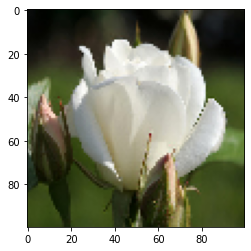

In [11]:
plt.imshow(images[0][0])

In [12]:
enc = OneHotEncoder()
labels = enc.fit_transform(labels.reshape(-1,1)).toarray()

In [13]:
labels

array([[0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0.]])

In [14]:
def build_cnn_model():
    cnn_model = tf.keras.Sequential([
        tf.keras.layers.Conv3D(filters=50, kernel_size=(3,3,3), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPool3D(pool_size=(2,2,2), padding='same'),
        tf.keras.layers.Dropout(.6),
        tf.keras.layers.Conv3D(filters=100, kernel_size=(5,5,5), activation=tf.nn.relu, padding='same'),
        tf.keras.layers.MaxPool3D(pool_size=(2,2,2), padding='same'),
        tf.keras.layers.Dropout(.6),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation=tf.nn.relu),
        tf.keras.layers.Dropout(.6),
        tf.keras.layers.Dense(64, activation=tf.nn.relu),
        tf.keras.layers.Dense(32, activation=tf.nn.relu),
        tf.keras.layers.Dense(20, activation=tf.nn.relu),
        tf.keras.layers.Dense(5, activation=tf.nn.softmax)
    ])
    return cnn_model
  
cnn_model = build_cnn_model()
sd=cnn_model.predict(images[0:40])
print(cnn_model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 1, 100, 100, 50)   4100      
                                                                 
 max_pooling3d (MaxPooling3D  (None, 1, 50, 50, 50)    0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 1, 50, 50, 50)     0         
                                                                 
 conv3d_1 (Conv3D)           (None, 1, 50, 50, 100)    625100    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 1, 25, 25, 100)   0         
 3D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 1, 25, 25, 100)    0

In [15]:
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=.2)

In [16]:
cnn_model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [17]:
y_train.shape

(3453, 5)

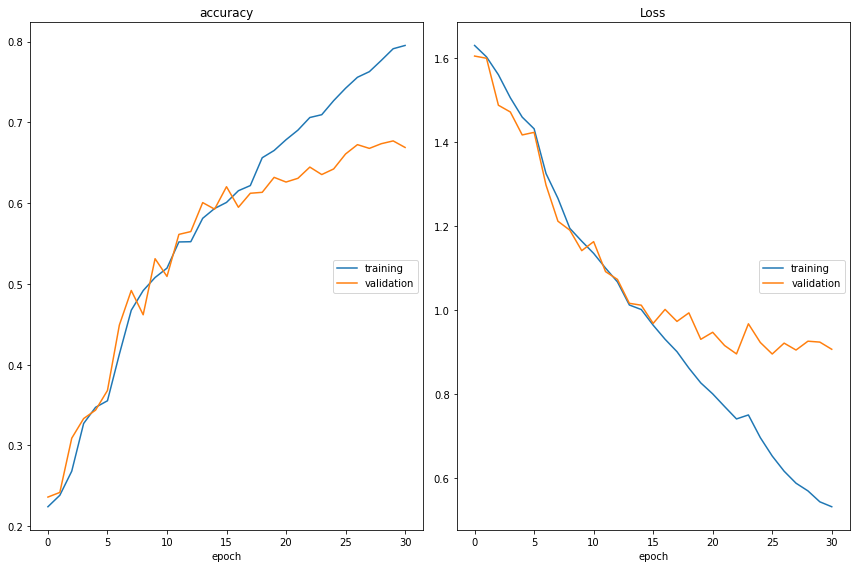

accuracy
	training         	 (min:    0.224, max:    0.795, cur:    0.795)
	validation       	 (min:    0.236, max:    0.677, cur:    0.669)
Loss
	training         	 (min:    0.532, max:    1.630, cur:    0.532)
	validation       	 (min:    0.896, max:    1.605, cur:    0.907)


In [18]:
history = cnn_model.fit(X_train, y_train, epochs = 100, verbose=0, batch_size =100, validation_data=(X_test, y_test), callbacks=[PlotLossesKeras(), tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    verbose=0,
    mode="auto",
    baseline=None,
    restore_best_weights=True,
)])

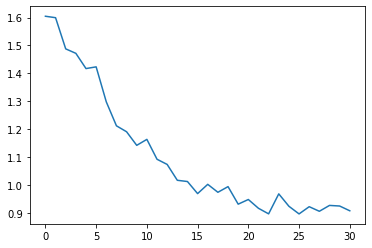

In [19]:
plt.plot(history.history['val_loss'])

In [20]:
from sklearn.metrics import classification_report, confusion_matrix

In [21]:
import keras
y_proba = cnn_model.predict(X_test)
y_classes = y_proba.argmax(axis=-1)

In [22]:
kk = np.zeros((len(y_classes), 5))
for ind, i in enumerate(kk):
  kk[ind][y_classes[ind]] = 1

In [23]:
kk

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [24]:
def getclass(x):
  return enc.categories_[0][x]

In [ ]:
list(map(getclass, y_classes))

In [26]:
enc.categories_[0][2]

'rose'

In [27]:
print(classification_report(kk, y_test))

              precision    recall  f1-score   support

           0       0.56      0.68      0.62       128
           1       0.81      0.64      0.72       266
           2       0.44      0.62      0.52       108
           3       0.80      0.76      0.78       153
           4       0.64      0.62      0.63       209

   micro avg       0.66      0.66      0.66       864
   macro avg       0.65      0.66      0.65       864
weighted avg       0.69      0.66      0.67       864
 samples avg       0.66      0.66      0.66       864



In [28]:
y_test

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 1., 0.],
       [0., 1., 0., 0., 0.]])

In [29]:
kk

array([[0., 1., 0., 0., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 0., 0., 1.],
       ...,
       [0., 0., 1., 0., 0.],
       [0., 1., 0., 0., 0.],
       [0., 1., 0., 0., 0.]])

In [30]:
df = (cv.resize((plt.imread('testing.jpg')), (100, 100), interpolation = cv.INTER_NEAREST))

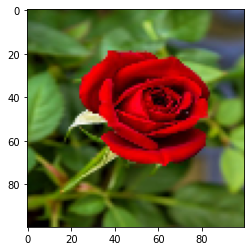

In [31]:
plt.imshow(df)

In [32]:
df.resize(1,1, 100, 100, 3)

In [33]:
print(enc.categories_[0][cnn_model.predict(df).argmax(axis=-1)[0]])

rose
